Кирилл Лалаянц, R33352

# Лабораторная работа No7
# В -- 11
## Управляемость и наблюдаемость

Импорт необходимых для работы библиотек. 

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy

SAVE_PATH = 'tex-report/src/figs/'
os.makedirs(SAVE_PATH, exist_ok=True)

sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I


def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

## Task1

In [17]:
task1_A = np.array([
    [3, 4, -1],
    [-10, -11, -4],
    [10, 10, 3]
])

task1_B = np.array([[-2], [5], [-3]])

task1_x1 = np.array([[-2], [1], [-1]])
task1_end_time = 3

In [18]:
def get_controllability_matrix(A, B):
    ctrb_m = np.hstack((B, *[(np.linalg.matrix_power(A, i)) @ B for i in range(1, A.shape[0])]))
    assert np.allclose(control.ctrb(A, B), ctrb_m), 'Smth wrong'
    return ctrb_m

def check_controllability(A, B, end_time):
    print('======== System check ==========')
    A_sympy, B_sympy = sympy.Matrix(A), sympy.Matrix(B)
    U = get_controllability_matrix(A, B)
    print(f'U: \n{U}')
    print(f'RankU = {np.linalg.matrix_rank(U)}')
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {val}: {'controllable' if np.linalg.matrix_rank(np.hstack(((A - val * np.eye(A.shape[0])), B))) == A.shape[0] else 'not controllable'}")
    A_P, A_J = A_sympy.jordan_form()
    print(f'Jordan of A: {A_J}')
    print(f'B^ = {(A_P ** -1 ) * B_sympy}')
    control_gramian_matrix, control_gramian_error = get_controllability_gramian(A, B, end_time)
    print(f'Controllability Gramian at {end_time}s: \n{control_gramian_matrix}')
    print(f'Eigen values of Controllability Gramian at {end_time}s: {np.linalg.eigvals(control_gramian_matrix)}')
    

def check_controllability_of_point(A, B, x1):
    print(f'======== Controllability of {x1.reshape(-1)} ==========')
    U = get_controllability_matrix(A, B)
    rgU = np.linalg.matrix_rank(U)
    print(f'Rang(U): \n {rgU}')
    
    U_extended = np.hstack((U, x1))
    rgU_extended = np.linalg.matrix_rank(np.hstack((U, x1)))
    print(f'U_ext: \n {U_extended}')
    print(f'Rang(U_ext) = {rgU_extended}')
    
    controllable =  rgU_extended == rgU
    print(f'In Controllable Space: {controllable}')
    return controllable

def get_controllability_gramian(A, B, end_time):
    f = lambda time: scipy.linalg.expm(A * time) @ B @ B.T @ scipy.linalg.expm(A.T * time)
    return scipy.integrate.quad_vec(f, 0, end_time)

def get_u_for_controllable(A, B, x1, end_time):
    u = []
    times = get_t(end_time)
    control_gramian_matrix, _ = get_controllability_gramian(A, B, end_time)
    print(control_gramian_matrix @ np.linalg.inv(control_gramian_matrix))
    for t in times:
        u.append(B.T @ scipy.linalg.expm(A.T * (end_time - t)) @ np.linalg.pinv(control_gramian_matrix) @ x1)
    return np.array(u).reshape((B.shape[1], -1)), times

def plot_task1(A, B, x1, end_time, file_name='test.jpg'):
    u, times = get_u_for_controllable(A, B, x1, end_time)
    ss = control.ss(A, B, A * 0, B * 0)
    output = control.forced_response(ss, X0=[0,0,0], U=u, T=times).states

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(3):
        axs[i//2, i % 2].plot(times, output[i], linewidth=4)
        axs[i//2, i % 2].scatter(end_time, x1[i], color='r', linewidth=4, label='goal')
        axs[i//2, i % 2].set_title(f'x_{i} = x_{i}(t)', fontsize=12)
        axs[i//2, i % 2].set_xlabel(f"t, [s]", fontsize=12)
        axs[i//2, i % 2].grid(True)
        axs[i//2, i % 2].legend()
        
        
    axs[1, 1].plot(times, u.reshape(-1), linewidth=4)
    axs[1, 1].set_title(f'u = u(t)', fontsize=12)
    axs[1, 1].set_xlabel(f"t, [s]", fontsize=12)
    axs[1, 1].grid(True)
    plt.savefig(f'{SAVE_PATH}/{file_name}.jpg') 

In [19]:
check_controllability(task1_A, task1_B, task1_end_time)
check_controllability_of_point(task1_A, task1_B, task1_x1)

======== System check ==========
U: 
[[ -2  17 -62]
 [  5 -23  -1]
 [ -3  21   3]]
RankU = 3
Eigen values of A:
   (-1.9999999999999978+5.000000000000001j): controllable
   (-1.9999999999999978-5.000000000000001j): controllable
   (-1.0000000000000007+0j): controllable
Jordan of A: Matrix([[-1, 0, 0], [0, -2 - 5*I, 0], [0, 0, -2 + 5*I]])
B^ = Matrix([[2], [-3/2 + 3*I/2], [-3/2 - 3*I/2]])
Controllability Gramian at 3s: 
[[ 1.20007932 -1.34167992  0.2290306 ]
 [-1.34167992  2.76344352 -1.12126199]
 [ 0.2290306  -1.12126199  1.47412296]]
Eigen values of Controllability Gramian at 3s: [4.00714483 0.27420078 1.15630018]
======== Controllability of [-2  1 -1] ==========
Rang(U): 
 3
U_ext: 
 [[ -2  17 -62  -2]
 [  5 -23  -1   1]
 [ -3  21   3  -1]]
Rang(U_ext) = 3
In Controllable Space: True


True

[[ 1.00000000e+00  2.32413069e-16 -2.67873543e-16]
 [ 1.19909592e-16  1.00000000e+00  2.16170171e-16]
 [-2.14524225e-16 -1.95235097e-16  1.00000000e+00]]


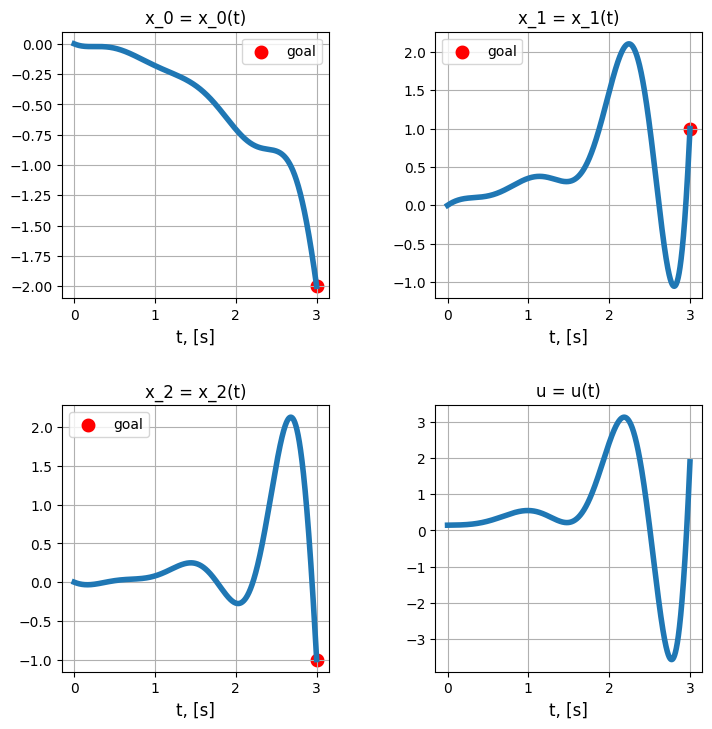

In [20]:
plot_task1(task1_A, task1_B, task1_x1, task1_end_time, 'task1')

## Task 2

In [21]:
task2_A = np.array([
    [3, 4, -1],
    [-10, -11, -4],
    [10, 10, 3]
])

task2_B = np.array([[2], [1], [-1]])

task2_mbx1 = np.array([[-2], [1], [-1]])
task2_mbx2 = np.array([[-5], [4], [-1]])

task2_end_time = 3

In [22]:
check_controllability(task2_A, task2_B, task2_end_time)
is_mbx1 = check_controllability_of_point(task2_A, task2_B, task2_mbx1)
is_mbx2 = check_controllability_of_point(task2_A, task2_B, task2_mbx2)

assert is_mbx1 + is_mbx2 == 1, 'Two or zero controllable points'
task2_x1 = task2_mbx1 if is_mbx1 else task2_mbx2

======== System check ==========
U: 
[[   2   11 -102]
 [   1  -27   79]
 [  -1   27  -79]]
RankU = 2
Eigen values of A:
   (-1.9999999999999978+5.000000000000001j): controllable
   (-1.9999999999999978-5.000000000000001j): controllable
   (-1.0000000000000007+0j): not controllable
Jordan of A: Matrix([[-1, 0, 0], [0, -2 - 5*I, 0], [0, 0, -2 + 5*I]])
B^ = Matrix([[0], [-1/2 + 5*I/2], [-1/2 - 5*I/2]])
Controllability Gramian at 3s: 
[[ 2.05602665 -1.63361588  1.63361588]
 [-1.63361588  2.40515848 -2.40515848]
 [ 1.63361588 -2.40515848  2.40515848]]
Eigen values of Controllability Gramian at 3s: [ 7.43575100e-01  6.12276851e+00 -4.05992379e-16]
======== Controllability of [-2  1 -1] ==========
Rang(U): 
 2
U_ext: 
 [[   2   11 -102   -2]
 [   1  -27   79    1]
 [  -1   27  -79   -1]]
Rang(U_ext) = 2
In Controllable Space: True
======== Controllability of [-5  4 -1] ==========
Rang(U): 
 2
U_ext: 
 [[   2   11 -102   -5]
 [   1  -27   79    4]
 [  -1   27  -79   -1]]
Rang(U_ext) = 3
In Co

[[ 1.00000000e+00  1.11723336e-01 -7.14687254e-02]
 [-1.74686879e-16  4.73846774e-01 -2.28732466e-01]
 [ 5.42099603e-17  4.75293964e-01  1.17787320e+00]]


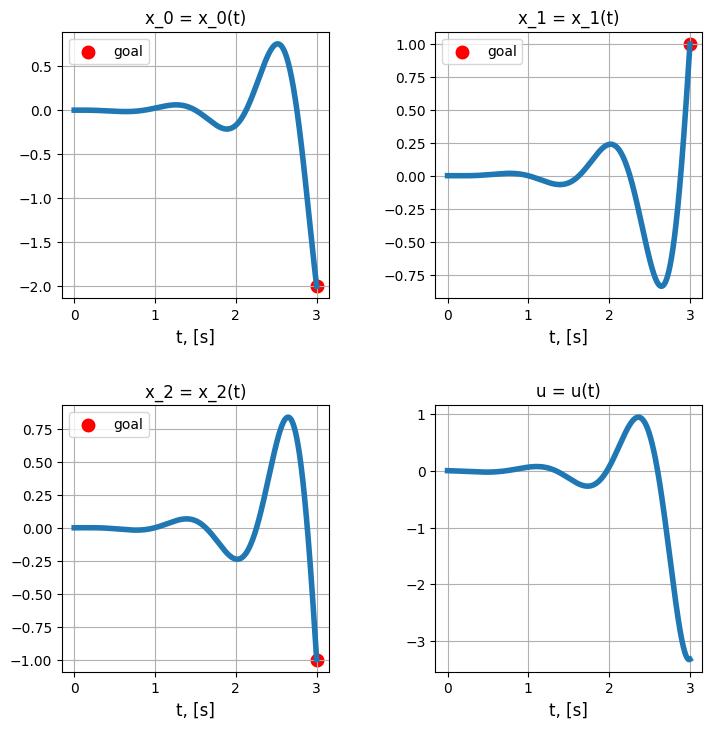

In [23]:
plot_task1(task2_A, task2_B, task2_x1, task2_end_time, 'task2')

## Task3

In [24]:
task3_A = np.array([
    [-21, -38, 6],
    [8, 13, -4],
    [-6, -14, -1]
])

task3_C = np.array([9, 18, -2]).reshape((1, 3))

task3_y = lambda x: 3 * np.exp(-5 * x) * np.cos(2 * x) - np.exp(-5 * x) * np.sin(2 * x)

task3_end_time = 3

In [25]:
def get_observability_matrix(A, C):
    ctrb_m = np.vstack((C, *[C @ np.linalg.matrix_power(A, i) for i in range(1, A.shape[0])]))
    assert np.allclose(control.obsv(A, C), ctrb_m), 'Smth wrong'
    return ctrb_m

def get_observability_gramian(A, C, end_time):
    f = lambda time: scipy.linalg.expm(A.T * time) @ C.T @ C @ scipy.linalg.expm(A * time)
    return scipy.integrate.quad_vec(f, 0, end_time)

def check_observability(A, C, end_time):
    print('======== System check ==========')
    A_sympy, C_sympy = sympy.Matrix(A), sympy.Matrix(C)
    V = get_observability_matrix(A, C)
    print(f'V: \n{V}')
    print(f'RankV = {np.linalg.matrix_rank(V)}')
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {val}: {'observable' if np.linalg.matrix_rank(np.vstack(((A - val * np.eye(A.shape[0])), C))) == A.shape[0] else 'not observable'}")
    A_P, A_J = A_sympy.jordan_form()
    print(f'Jordan of A: {A_J}')
    print(f'C^ = {C_sympy * A_P}')
    observability_gramian_matrix, observability_gramian_error = get_observability_gramian(A, C, end_time)
    print(f'Observability Gramian at {end_time}s: \n{observability_gramian_matrix}')
    print(f'Eigen values of Observability Gramian at {end_time}s: {np.linalg.eigvals(observability_gramian_matrix)}')
    

def check_non_observability_of_point(A, C, x1):
    print(f'======== Non observability of {x1.reshape(-1)} ==========')
    V = get_observability_matrix(A, C)
    non_observable = np.allclose(V @ x1, 0)
    print(f'In Non observable Space: {non_observable}')
    return non_observable

def get_initial_state_for_observable(A, C, y_lambda, end_time):
    observability_gramian_matrix, _ = get_observability_gramian(A, C, end_time)
    f = lambda time: scipy.linalg.expm(A.T * time) @ C.T @ np.array(y_lambda(time)).reshape(C.shape[0], -1)
    inv_gramian = np.linalg.pinv(observability_gramian_matrix)
    return inv_gramian @ scipy.integrate.quad_vec(f, 0, end_time)[0]

def plot_task3(A, C, y_lambda, end_time, file_name='test.jpg'):
    times = get_t(3)
    x0 = get_initial_state_for_observable(A, C, y_lambda, end_time)
    ss = control.ss(A, A * 0, C, C * 0)
    res = control.forced_response(ss, X0=x0, U=0, T=times)
    output = res.states

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(3):
        axs[i//2, i % 2].plot(times, output[i], linewidth=4)
        axs[i//2, i % 2].scatter(0, x0[i], color='r', linewidth=4, label='initial')
        axs[i//2, i % 2].set_title(f'x_{i} = x_{i}(t)', fontsize=12)
        axs[i//2, i % 2].set_xlabel(f"t, [s]", fontsize=12)
        axs[i//2, i % 2].grid(True)
        axs[i//2, i % 2].legend()
        
        
    axs[1, 1].plot(times, res.outputs.reshape(-1), linewidth=4)
    axs[1, 1].scatter(0, C @ x0, color='r', linewidth=4, label='initial')
    axs[1, 1].set_title(f'y = y(t)', fontsize=12)
    axs[1, 1].set_xlabel(f"t, [s]", fontsize=12)
    axs[1, 1].grid(True)
    plt.savefig(f'{SAVE_PATH}/{file_name}.jpg') 
    return x0

======== System check ==========
V: 
[[  9  18  -2]
 [-33 -80 -16]
 [149 438 138]]
RankV = 3
Eigen values of A:
   (1.0000000000000169+0j): observable
   (-5.000000000000002+1.999999999999992j): observable
   (-5.000000000000002-1.999999999999992j): observable
Jordan of A: Matrix([[1, 0, 0], [0, -5 - 2*I, 0], [0, 0, -5 + 2*I]])
C^ = Matrix([[-2, 7, 7]])
Observability Gramian at 3s: 
[[  815.01961811  1627.79441208  -809.9023922 ]
 [ 1627.79441208  3251.43710693 -1618.06685681]
 [ -809.9023922  -1618.06685681   807.99551112]]
Eigen values of Observability Gramian at 3s: [4.87201653e+03 5.70726112e-02 2.37863082e+00]


array([], shape=(3, 0), dtype=float64)

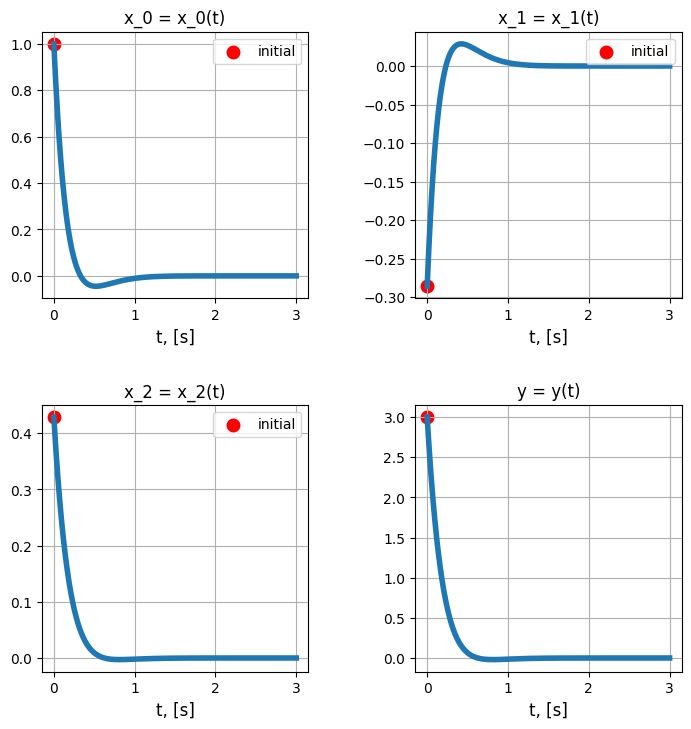

In [26]:
check_observability(task3_A, task3_C, task3_end_time)
plot_task3(task3_A, task3_C, task3_y, task3_end_time, 'task3')
V = get_observability_matrix(task3_A, task3_C)
null_space_vec = scipy.linalg.null_space(V)
null_space_vec

## Task4

In [27]:
def task4_demonstate_nullspace(A, C, x0, file_name='test'):
    V = get_observability_matrix(A, C)
    null_space_vec = scipy.linalg.null_space(V)
    print(null_space_vec)
    times = get_t(3)
    ss = control.ss(A, A * 0, C, C * 0)
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(4):
        new_x0 = x0 + 10 * i * null_space_vec
        res = control.forced_response(ss, X0=new_x0, U=0, T=times)
        output = res.states
        for i in range(3):
            axs[i//2, i % 2].plot(times, output[i], linewidth=4)
            axs[i//2, i % 2].scatter(0, new_x0[i], linewidth=4, label=f'{new_x0[i]}')
            axs[i//2, i % 2].set_title(f'x_{i} = x_{i}(t)', fontsize=12)
            axs[i//2, i % 2].set_xlabel(f"t, [s]", fontsize=12)
            axs[i//2, i % 2].grid(True)
            axs[i//2, i % 2].legend()
            
            
        axs[1, 1].plot(times, res.outputs.reshape(-1), linewidth=4)
        axs[1, 1].scatter(0, C @ x0, color='r', linewidth=4, label=f'{x0 + i * null_space_vec}')
        axs[1, 1].set_title(f'y = y(t)', fontsize=12)
        axs[1, 1].set_xlabel(f"t, [s]", fontsize=12)
        axs[1, 1].grid(True)
    plt.savefig(f'{SAVE_PATH}/{file_name}.jpg') 
    

In [28]:
task4_A = np.array([
    [-21, -38, 6],
    [8, 13, -4],
    [-6, -14, -1]
])

task4_C = np.array([7, 14, 0]).reshape((1, 3))

task4_y = lambda x: 3 * np.exp(-5 * x) * np.cos(2 * x) - np.exp(-5 * x) * np.sin(2 * x)

task4_end_time = 3

======== System check ==========
V: 
[[  7  14   0]
 [-35 -84 -14]
 [147 434 140]]
RankV = 2
Eigen values of A:
   (1.0000000000000169+0j): not observable
   (-5.000000000000002+1.999999999999992j): observable
   (-5.000000000000002-1.999999999999992j): observable
Jordan of A: Matrix([[1, 0, 0], [0, -5 - 2*I, 0], [0, 0, -5 + 2*I]])
C^ = Matrix([[0, 7, 7]])
Observability Gramian at 3s: 
[[ 4.56206897  8.27931034 -0.84482759]
 [ 8.27931034 15.20689655 -1.35172414]
 [-0.84482759 -1.35172414  0.33793103]]
Eigen values of Observability Gramian at 3s: [1.98567251e+01 1.01232818e-15 2.50171475e-01]


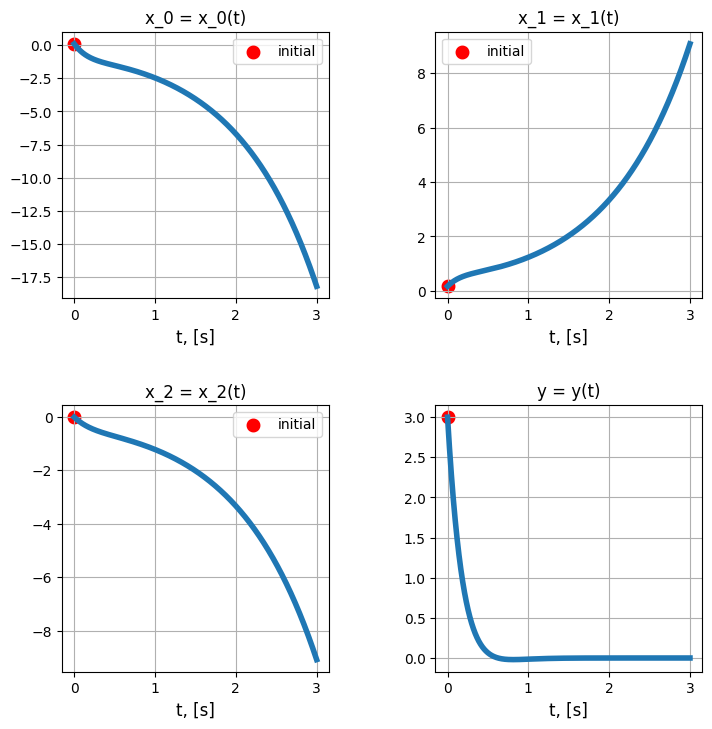

In [29]:
check_observability(task4_A, task4_C, task4_end_time)
task4_x0 = plot_task3(task4_A, task4_C, task4_y, task4_end_time, 'task4')

[[-0.81649658]
 [ 0.40824829]
 [-0.40824829]]


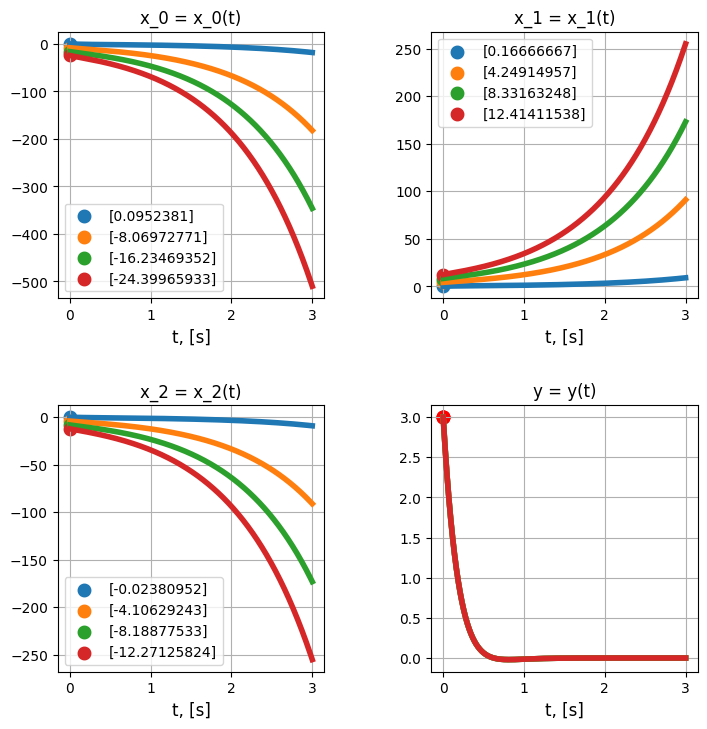

In [30]:
task4_demonstate_nullspace(task4_A, task4_C, task4_x0, 'task4_nullspace')